In [4]:
# General
import os, sys, glob, math, random
import numpy as np
import matplotlib.pyplot as plt

# Image & CV
import cv2
from skimage import exposure, feature, morphology, filters, measure, restoration, util, color
from skimage.feature import graycomatrix, graycoprops, hog
from skimage.segmentation import watershed
from scipy import ndimage as ndi

# Matplotlib defaults for nicer plots
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["image.cmap"] = "gray"
np.set_printoptions(suppress=True)

print("Versions ->",
      "cv2", cv2.__version__,
      "| numpy", np.__version__)


Versions -> cv2 4.12.0 | numpy 1.26.4


In [5]:
# Try to locate knee X-ray images anywhere under /kaggle/input
IMG_EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")
INPUT_ROOT = "/kaggle/input"

all_images = []
for root, _, files in os.walk(INPUT_ROOT):
    for f in files:
        if f.lower().endswith(IMG_EXTS):
            all_images.append(os.path.join(root, f))

all_images = sorted(all_images)
print(f"Found {len(all_images)} images.")
print("Sample paths:", *all_images[:5], sep="\n")

assert len(all_images) > 0, "No images found under /kaggle/input. Add/attach the dataset first."


Found 3300 images.
Sample paths:
/kaggle/input/digital-knee-x-ray-images/Digital Knee X-ray Images/Digital Knee X-ray Images/Knee X-ray Images/MedicalExpert-I/MedicalExpert-I/0Normal/NormalG0 (1).png
/kaggle/input/digital-knee-x-ray-images/Digital Knee X-ray Images/Digital Knee X-ray Images/Knee X-ray Images/MedicalExpert-I/MedicalExpert-I/0Normal/NormalG0 (10).png
/kaggle/input/digital-knee-x-ray-images/Digital Knee X-ray Images/Digital Knee X-ray Images/Knee X-ray Images/MedicalExpert-I/MedicalExpert-I/0Normal/NormalG0 (100).png
/kaggle/input/digital-knee-x-ray-images/Digital Knee X-ray Images/Digital Knee X-ray Images/Knee X-ray Images/MedicalExpert-I/MedicalExpert-I/0Normal/NormalG0 (101).png
/kaggle/input/digital-knee-x-ray-images/Digital Knee X-ray Images/Digital Knee X-ray Images/Knee X-ray Images/MedicalExpert-I/MedicalExpert-I/0Normal/NormalG0 (102).png


Sample image: /kaggle/input/digital-knee-x-ray-images/Digital Knee X-ray Images/Digital Knee X-ray Images/Knee X-ray Images/MedicalExpert-II/MedicalExpert-II/0Normal/NormalG0 (1).png shape: (162, 300) dtype: float32


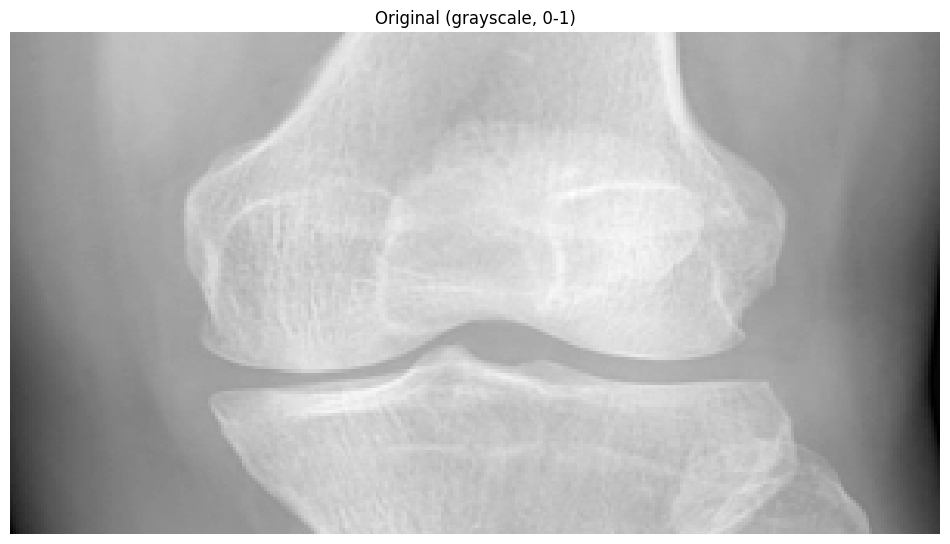

In [6]:
def imread_gray(path):
    """Read as grayscale float [0,1]."""
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Failed to read image: {path}")
    return img.astype(np.float32) / 255.0

def show_grid(images, titles=None, ncols=3, vmax=1.0):
    n = len(images)
    ncols = min(ncols, n)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
    axes = np.array(axes).reshape(nrows, ncols)
    for i, ax in enumerate(axes.ravel()):
        if i < n:
            im = images[i]
            ax.imshow(im, vmin=0, vmax=vmax, cmap='gray')
            if titles:
                ax.set_title(titles[i], fontsize=11)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def to_uint8(img):
    """Normalize to [0,255] uint8 for OpenCV ops needing 8-bit."""
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 1)
        img = (img*255).astype(np.uint8)
    return img

# Pick a representative image (middle of the list)
sample_path = all_images[len(all_images)//2]
img = imread_gray(sample_path)
print("Sample image:", sample_path, "shape:", img.shape, "dtype:", img.dtype)
plt.imshow(img); plt.title("Original (grayscale, 0-1)"); plt.axis('off'); plt.show()


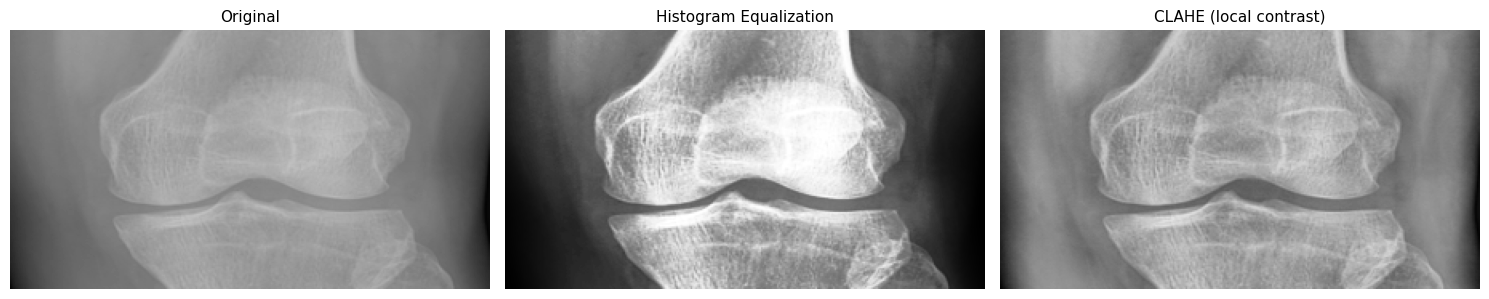

In [7]:
# Explanation:
# - Global Histogram Equalization spreads overall contrast.
# - CLAHE improves local contrast (great for X-rays) and avoids over-amplifying noise.

he = exposure.equalize_hist(img)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(to_uint8(img))/255.0

show_grid(
    [img, he, clahe],
    ["Original", "Histogram Equalization", "CLAHE (local contrast)"]
)


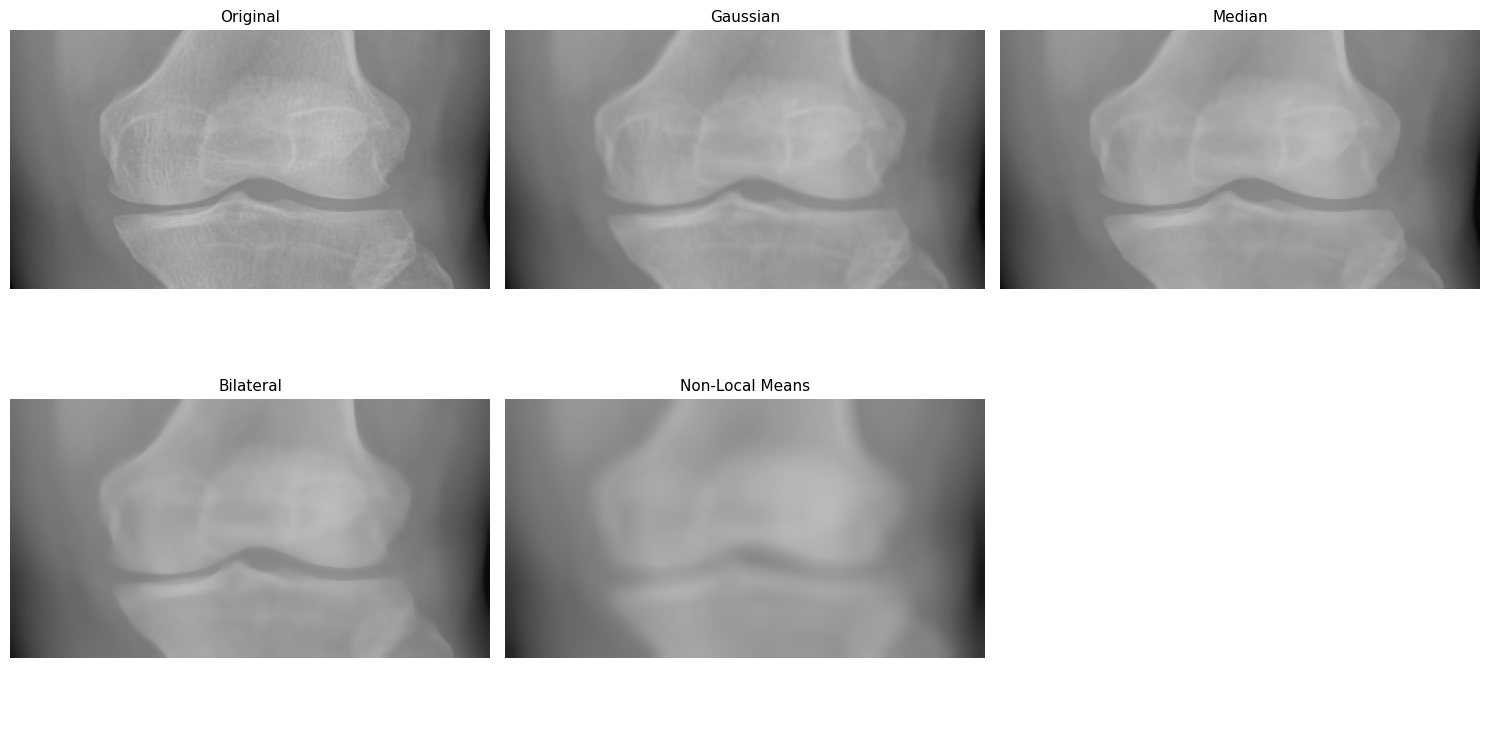

In [8]:
g_blur = cv2.GaussianBlur(img, (5,5), 1)
median = cv2.medianBlur(to_uint8(img), 5)/255.0
bilateral = cv2.bilateralFilter(to_uint8(img), d=9, sigmaColor=20, sigmaSpace=20)/255.0

# Non-local means (slower but preserves edges)
nlm = restoration.denoise_nl_means(img, patch_size=5, patch_distance=6, h=0.8, fast_mode=True, channel_axis=None)

show_grid(
    [img, g_blur, median, bilateral, nlm],
    ["Original", "Gaussian", "Median", "Bilateral", "Non-Local Means"]
)


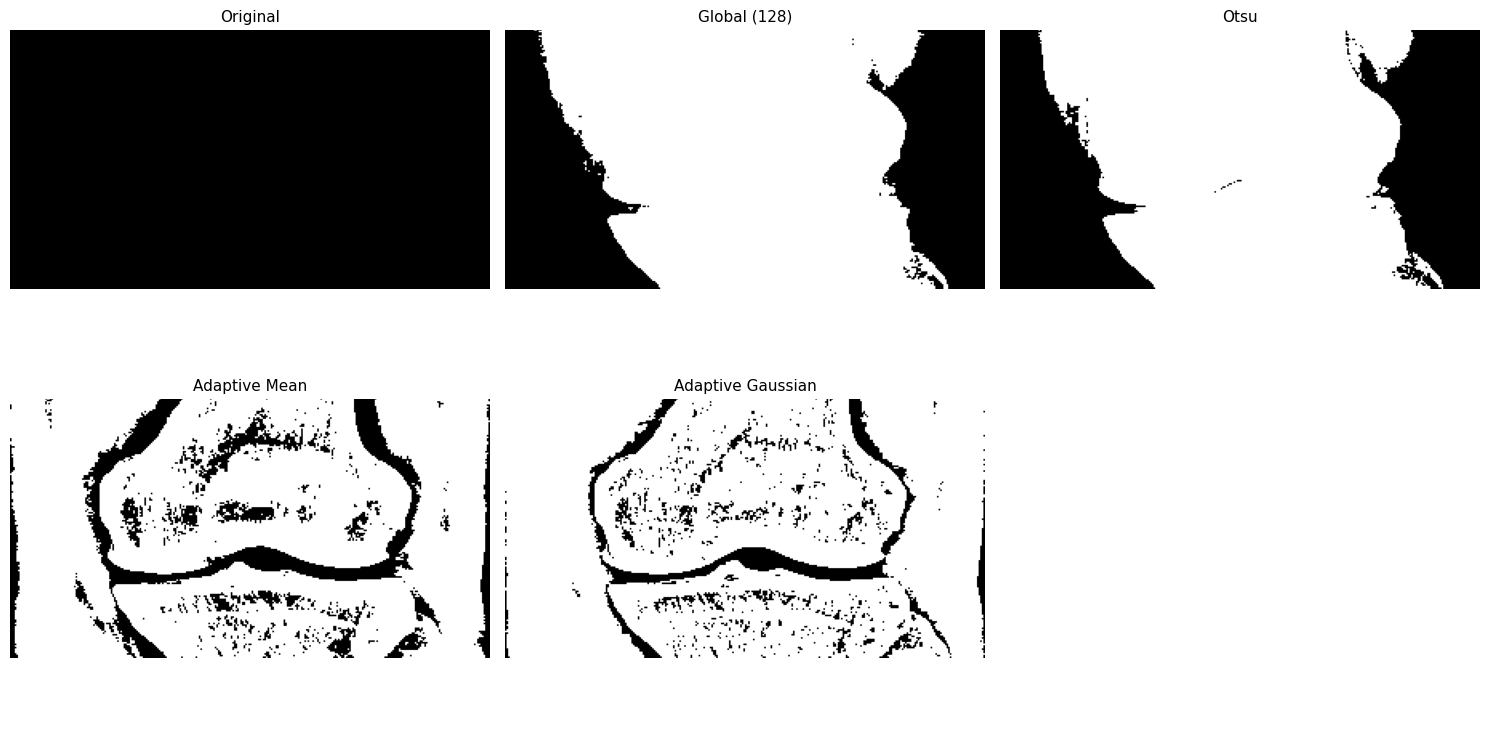

In [9]:
u8 = to_uint8(img)
_, th_global = cv2.threshold(u8, 128, 255, cv2.THRESH_BINARY)
# Otsu chooses threshold that maximizes inter-class variance
_, th_otsu = cv2.threshold(u8, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# Adaptive considers local neighborhoods
th_adapt_mean = cv2.adaptiveThreshold(u8, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 5)
th_adapt_gauss = cv2.adaptiveThreshold(u8, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 35, 5)

show_grid(
    [img, th_global, th_otsu, th_adapt_mean, th_adapt_gauss],
    ["Original", "Global (128)", "Otsu", "Adaptive Mean", "Adaptive Gaussian"],
    ncols=3, vmax=255
)


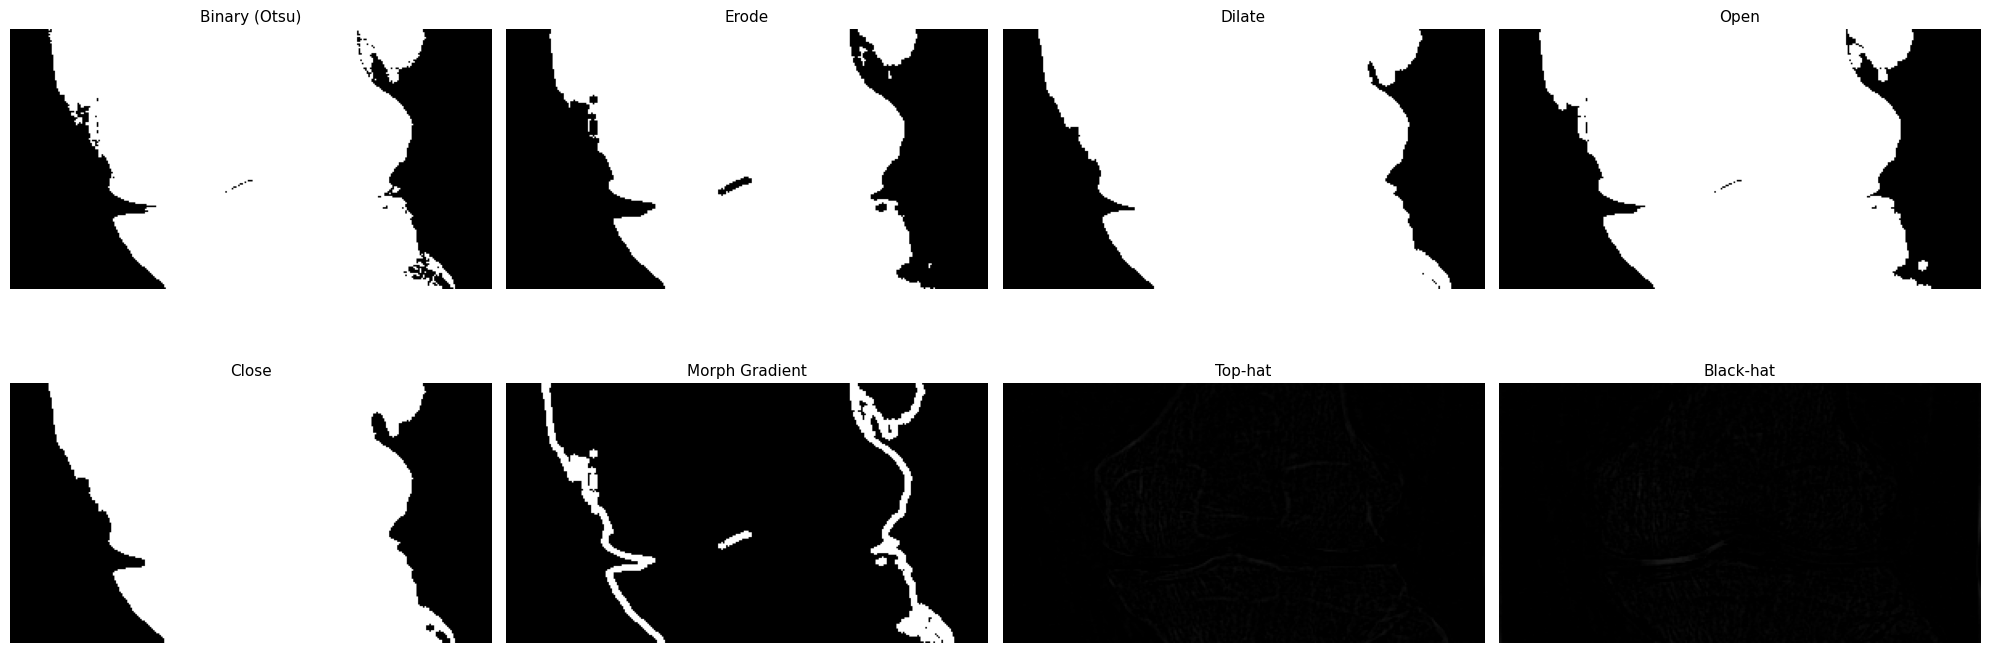

In [10]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
bin_img = (th_otsu > 0).astype(np.uint8)*255

erode  = cv2.erode(bin_img, kernel, iterations=1)
dilate = cv2.dilate(bin_img, kernel, iterations=1)
opening = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel)   # remove small white specks
closing = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, kernel)  # fill small black holes
gradient = cv2.morphologyEx(bin_img, cv2.MORPH_GRADIENT, kernel)  # edges
tophat = cv2.morphologyEx(u8, cv2.MORPH_TOPHAT, kernel)       # bright on dark background
blackhat = cv2.morphologyEx(u8, cv2.MORPH_BLACKHAT, kernel)   # dark on bright background

show_grid(
    [bin_img, erode, dilate, opening, closing, gradient, tophat, blackhat],
    ["Binary (Otsu)", "Erode", "Dilate", "Open", "Close", "Morph Gradient", "Top-hat", "Black-hat"],
    ncols=4, vmax=255
)


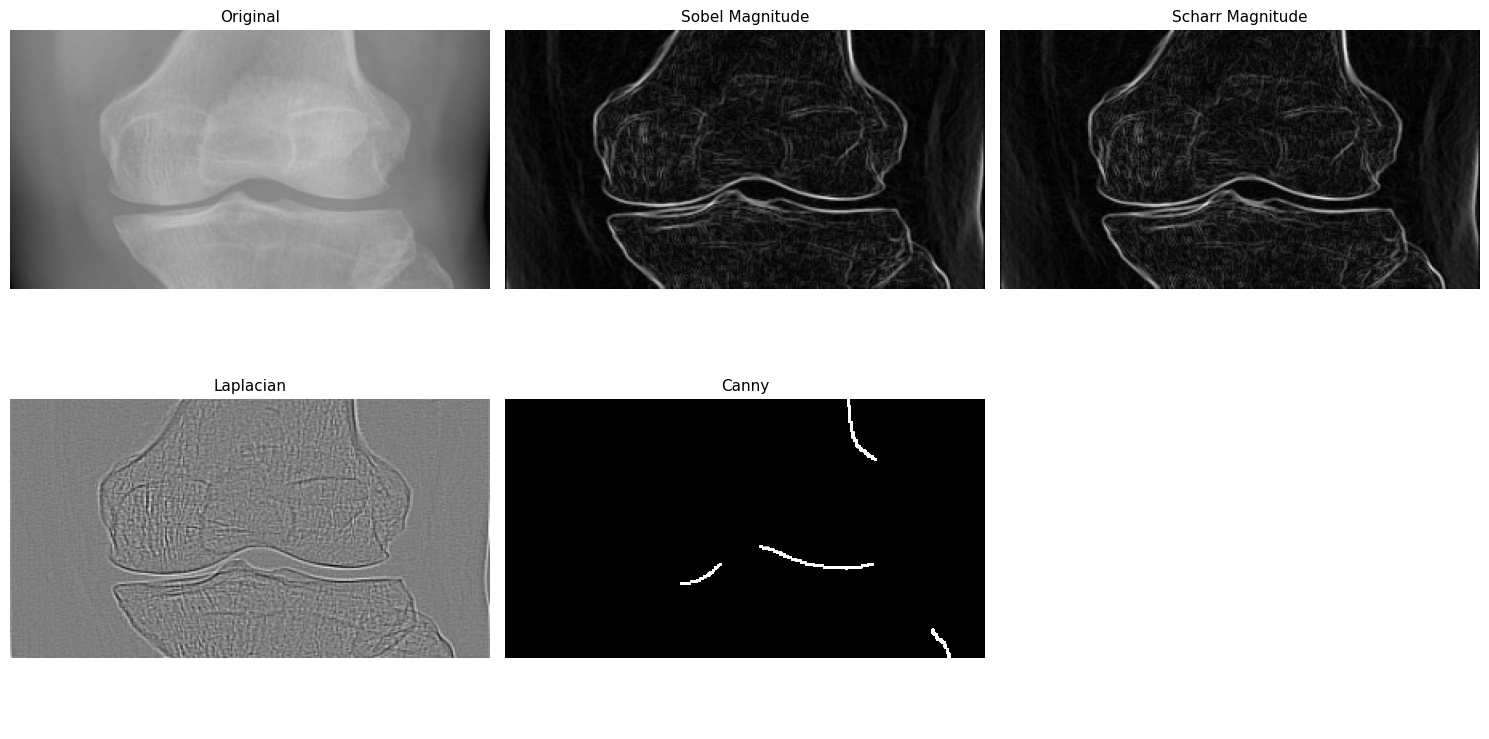

In [11]:
# Sobel gradients
sx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
sy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
sobel_mag = np.sqrt(sx**2 + sy**2)

# Scharr (stronger derivative operator)
scharr = cv2.Scharr(img, cv2.CV_32F, 1, 0)**2 + cv2.Scharr(img, cv2.CV_32F, 0, 1)**2
scharr = np.sqrt(scharr)

# Laplacian (2nd derivative)
lap = cv2.Laplacian(img, cv2.CV_32F, ksize=3)

# Canny with auto thresholds from the image median
v = np.median(u8)
lower, upper = int(max(0, 0.66*v)), int(min(255, 1.33*v))
canny = cv2.Canny(u8, lower, upper)

show_grid(
    [img, sobel_mag/np.max(sobel_mag), scharr/np.max(scharr), (lap - lap.min())/(lap.ptp()+1e-8), canny],
    ["Original", "Sobel Magnitude", "Scharr Magnitude", "Laplacian", "Canny"],
    ncols=3, vmax=1.0
)


Contours found: 8
Contour 0: area=0.0, perimeter=0.0
Contour 1: area=0.0, perimeter=4.0
Contour 2: area=0.0, perimeter=0.0
Contour 3: area=7.0, perimeter=11.7
Contour 4: area=0.0, perimeter=2.0


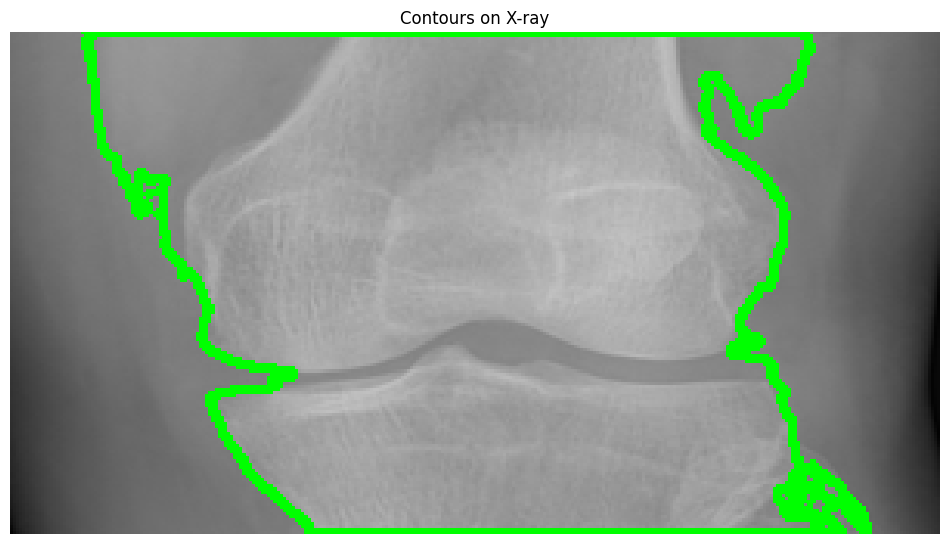

In [12]:
contours, hierarchy = cv2.findContours((th_otsu>0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print("Contours found:", len(contours))

overlay = cv2.cvtColor(to_uint8(img), cv2.COLOR_GRAY2BGR)
cv2.drawContours(overlay, contours, -1, (0,255,0), 2)

# Show a few contour areas/perimeters
for i, c in enumerate(contours[:5]):
    area = cv2.contourArea(c)
    peri = cv2.arcLength(c, True)
    print(f"Contour {i}: area={area:.1f}, perimeter={peri:.1f}")

plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.title("Contours on X-ray"); plt.axis('off'); plt.show()


Connected components (including background): 9


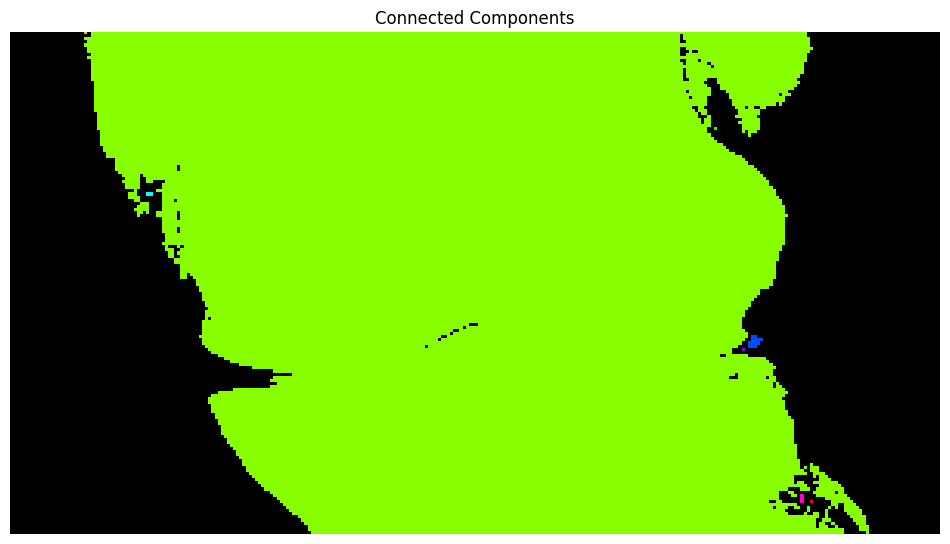

In [13]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats((th_otsu>0).astype(np.uint8), connectivity=8)
print("Connected components (including background):", num_labels)

# Colorize labels for visualization
label_hue = np.uint8(179*labels/np.max(labels) if np.max(labels)>0 else labels)
blank_ch = 255*np.ones_like(label_hue)
color_labels = cv2.cvtColor(cv2.merge([label_hue, blank_ch, blank_ch]), cv2.COLOR_HSV2RGB)
color_labels[label_hue==0] = 0
plt.imshow(color_labels); plt.title("Connected Components"); plt.axis('off'); plt.show()


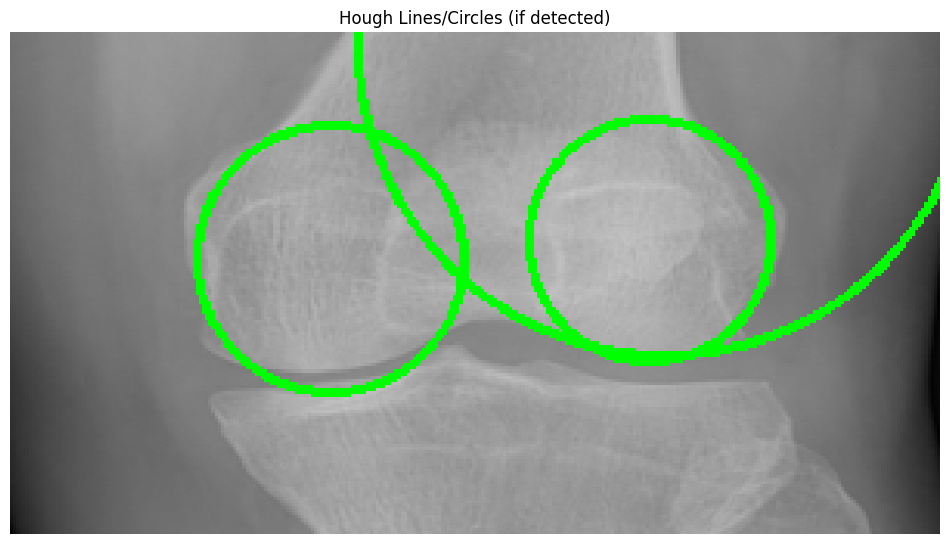

In [14]:
edges = cv2.Canny(u8, 50, 150)
color_img = cv2.cvtColor(to_uint8(img), cv2.COLOR_GRAY2BGR)

# Probabilistic Hough Lines (may find long cortical lines if present)
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=80, minLineLength=50, maxLineGap=10)
if lines is not None:
    for l in lines[:,0]:
        x1,y1,x2,y2 = l
        cv2.line(color_img, (x1,y1), (x2,y2), (255,0,0), 2)

# Hough Circles (often none in X-rays; just for demo)
circles = cv2.HoughCircles(u8, cv2.HOUGH_GRADIENT, dp=1.2, minDist=30, param1=80, param2=30, minRadius=10, maxRadius=120)
if circles is not None:
    circles = np.uint16(np.around(circles))
    for (x,y,r) in circles[0,:]:
        cv2.circle(color_img, (x,y), r, (0,255,0), 2)

plt.imshow(cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)); plt.title("Hough Lines/Circles (if detected)"); plt.axis('off'); plt.show()


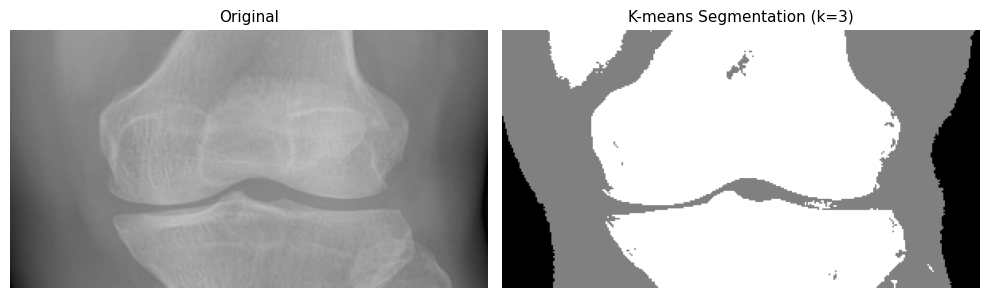

Cluster centers (darker to brighter): [0.28846818 0.47815564 0.63377625]


In [16]:
# K-means on intensities (k=3) to separate background/soft tissue/bone-ish regions
Z = img.reshape(-1,1).astype(np.float32)
K = 3
criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 50, 1e-3)
ret, labels_k, centers = cv2.kmeans(Z, K, None, criteria, 5, cv2.KMEANS_PP_CENTERS)
seg_k = labels_k.reshape(img.shape)
# Order clusters by intensity (for consistent visualization)
order = np.argsort(centers.ravel())
seg_ord = np.zeros_like(seg_k)
for i, o in enumerate(order):
    seg_ord[seg_k==o] = i

show_grid([img, seg_ord/(K-1)], ["Original", "K-means Segmentation (k=3)"])
print("Cluster centers (darker to brighter):", np.sort(centers.ravel()))


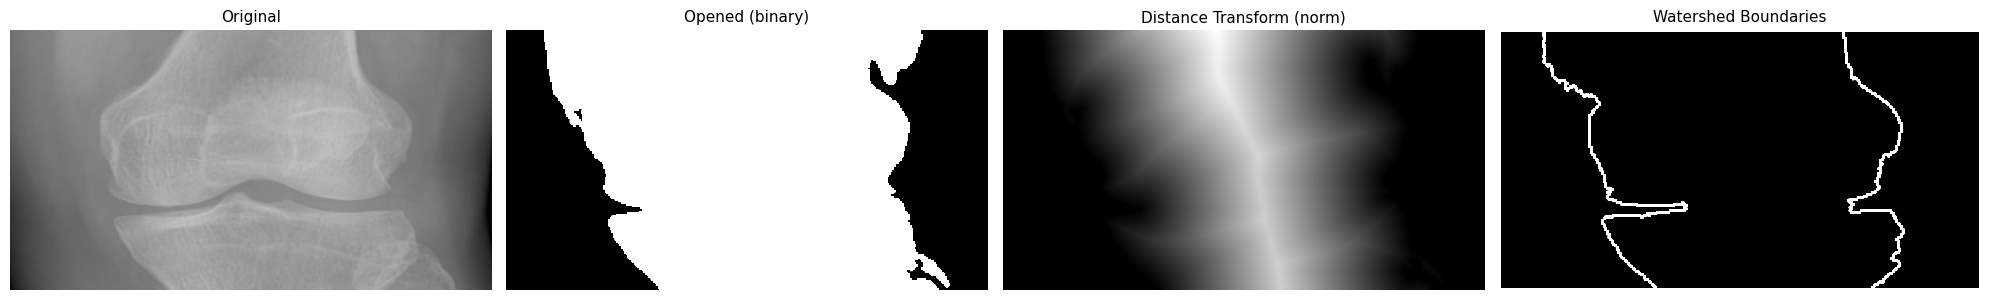

In [17]:
# Use morphological ops + distance transform to build markers for bone-like bright structures
blur = cv2.GaussianBlur(img, (5,5), 1)
th = cv2.threshold(to_uint8(blur), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
opened = cv2.morphologyEx(th, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)

# Distance transform to find sure-foreground
dist = cv2.distanceTransform(opened, cv2.DIST_L2, 5)
dist_norm = cv2.normalize(dist, None, 0, 1.0, cv2.NORM_MINMAX)
_, sure_fg = cv2.threshold((dist_norm*255).astype(np.uint8), 120, 255, cv2.THRESH_BINARY)

# Sure background
sure_bg = cv2.dilate(opened, np.ones((3,3), np.uint8), iterations=2)
unknown = cv2.subtract(sure_bg, sure_fg)

# Markers
num_labels, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown==255] = 0

# Watershed expects 3-channel image
img_color = cv2.cvtColor(to_uint8(img), cv2.COLOR_GRAY2BGR)
markers_ws = cv2.watershed(img_color, markers.copy())
# Boundaries are where markers == -1
boundary = (markers_ws == -1).astype(np.uint8)*255

show_grid([img, opened, dist_norm, boundary],
          ["Original", "Opened (binary)", "Distance Transform (norm)", "Watershed Boundaries"], ncols=4, vmax=1.0)


GLCM      contrast: 0.0743
GLCM dissimilarity: 0.0739
GLCM   homogeneity: 0.9631
GLCM           ASM: 0.3197
GLCM        energy: 0.5653
GLCM   correlation: 0.9529


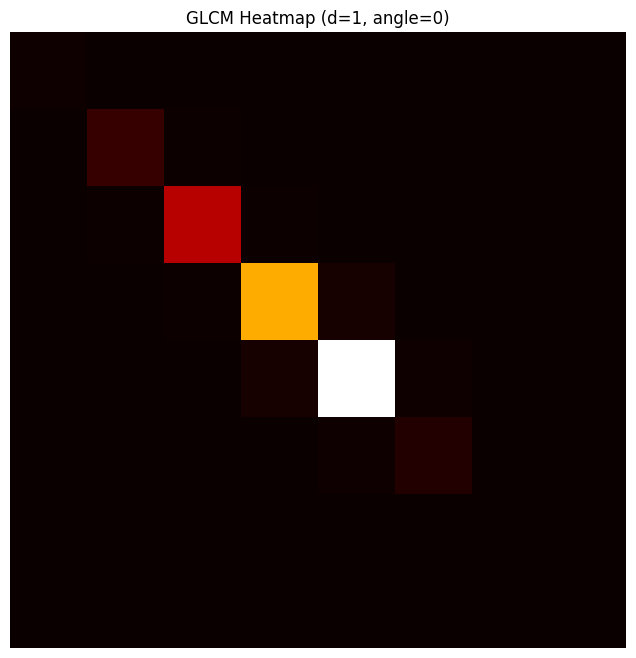

In [20]:
# Quantize to 8 levels (GLCM likes small integer ranges)
levels = 8
img_q = np.floor(img * (levels-1)).astype(np.uint8)
glcm = graycomatrix(img_q, distances=[1,2,4], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                    levels=levels, symmetric=True, normed=True)

props = ["contrast", "dissimilarity", "homogeneity", "ASM", "energy", "correlation"]
for p in props:
    vals = graycoprops(glcm, p).mean()
    print(f"GLCM {p:>13}: {vals:.4f}")

# Visualize one GLCM slice as a heatmap
glcm_img = glcm[:,:,0,0]
plt.imshow(glcm_img, cmap="hot"); plt.title("GLCM Heatmap (d=1, angle=0)"); plt.axis('off'); plt.show()


HOG feature length: 5508


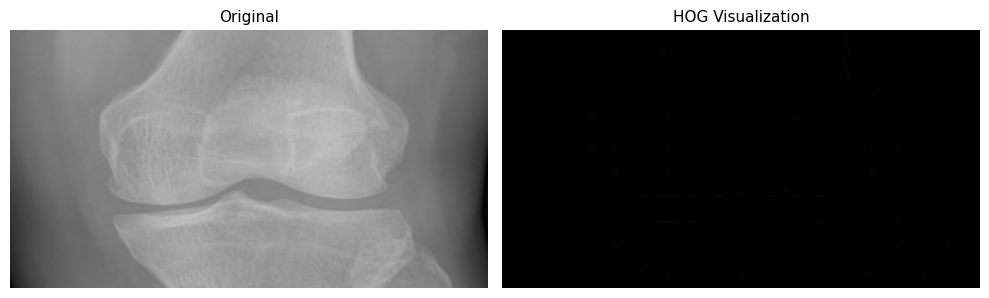

In [21]:
hog_feats, hog_img = hog(img, orientations=9, pixels_per_cell=(16,16),
                         cells_per_block=(2,2), visualize=True, feature_vector=True)
print("HOG feature length:", len(hog_feats))
show_grid([img, hog_img], ["Original", "HOG Visualization"])


ORB keypoints detected: 0 | Descriptor shape: None


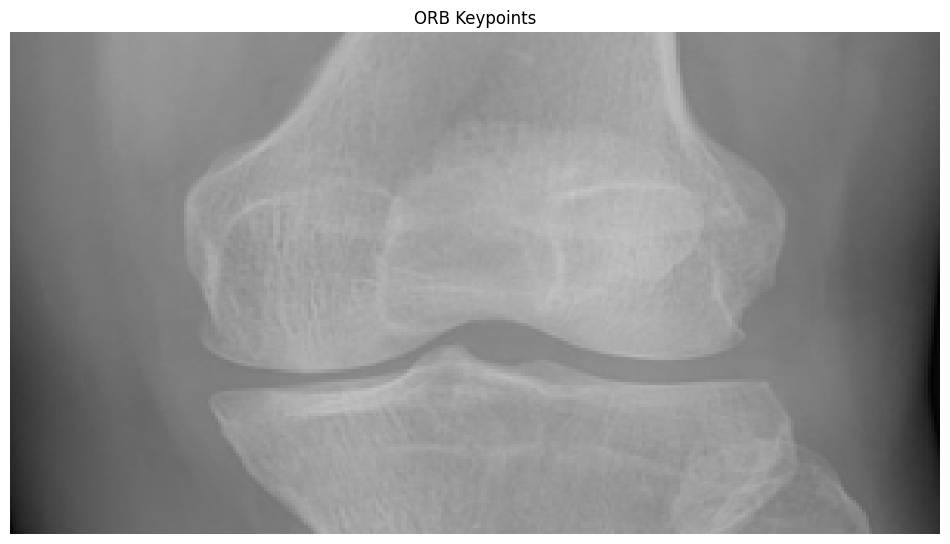

In [22]:
orb = cv2.ORB_create(nfeatures=800)
kps, des = orb.detectAndCompute(to_uint8(img), None)
print(f"ORB keypoints detected: {len(kps)} | Descriptor shape:", None if des is None else des.shape)

out = cv2.drawKeypoints(to_uint8(img), kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(out); plt.title("ORB Keypoints"); plt.axis('off'); plt.show()


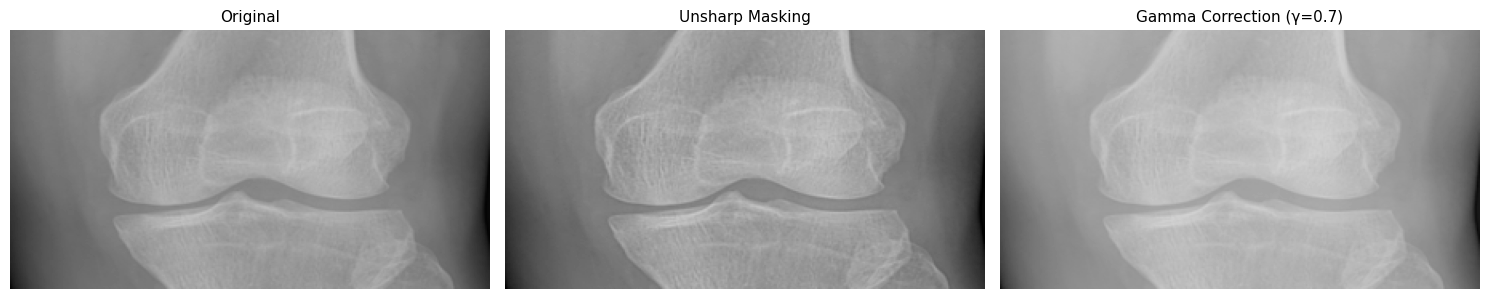

In [23]:
# Unsharp: sharp = img + amount*(img - Gaussian(img))
blur = cv2.GaussianBlur(img, (0,0), 2.0)
unsharp = cv2.addWeighted(img, 1.5, blur, -0.5, 0)

# Gamma: brighten bones (gamma<1 brightens)
gamma = 0.7
gamma_corr = np.power(np.clip(img, 0, 1), gamma)

show_grid([img, unsharp, gamma_corr], ["Original", "Unsharp Masking", f"Gamma Correction (γ={gamma})"])


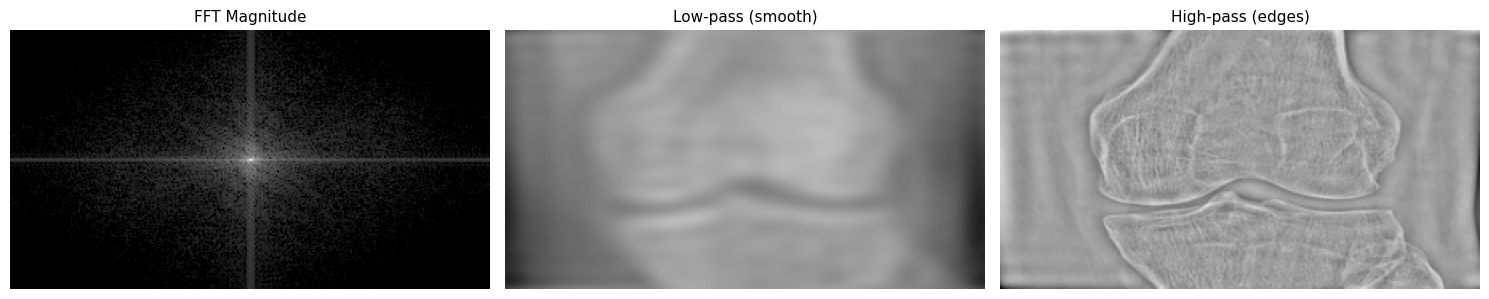

In [24]:
# Magnitude spectrum
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
mag = 20*np.log(np.abs(fshift)+1e-8)

# Ideal low-pass & high-pass masks
rows, cols = img.shape
crow, ccol = rows//2, cols//2
radius = min(rows, cols)//12

LP = np.zeros_like(img)
cv2.circle(LP, (ccol, crow), radius, 1, -1)
HP = 1 - LP

low = np.real(np.fft.ifft2(np.fft.ifftshift(fshift * LP)))
high = np.real(np.fft.ifft2(np.fft.ifftshift(fshift * HP)))

show_grid(
    [mag/np.max(mag), np.clip(low,0,1), (high - high.min())/(high.ptp()+1e-8)],
    ["FFT Magnitude", "Low-pass (smooth)", "High-pass (edges)"]
)


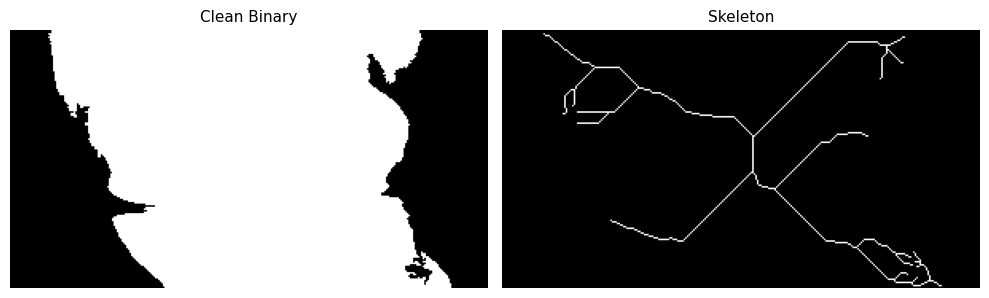

In [25]:
# Clean binary -> thin to 1-pixel wide skeleton (useful to trace structures)
bin_clean = morphology.remove_small_holes((th_otsu>0), area_threshold=256)
bin_clean = morphology.remove_small_objects(bin_clean, min_size=256)
skeleton = morphology.skeletonize(bin_clean)

show_grid([bin_clean, skeleton.astype(np.uint8)],
          ["Clean Binary", "Skeleton"], ncols=2, vmax=1.0)


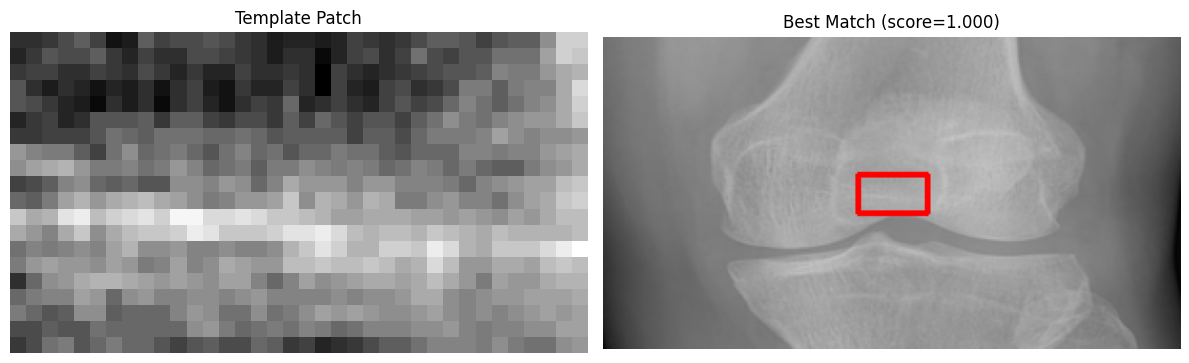

In [26]:
# Take a small patch from the center and try to find it in the image
h, w = img.shape
ph, pw = h//8, w//8
cy, cx = h//2, w//2
patch = img[cy-ph//2:cy+ph//2, cx-pw//2:cx+pw//2].copy()
res = cv2.matchTemplate(to_uint8(img), to_uint8(patch), cv2.TM_CCOEFF_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

top_left = max_loc
br = (top_left[0] + patch.shape[1], top_left[1] + patch.shape[0])
vis = cv2.cvtColor(to_uint8(img), cv2.COLOR_GRAY2BGR)
cv2.rectangle(vis, top_left, br, (0,0,255), 2)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(patch); plt.title("Template Patch"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.title(f"Best Match (score={max_val:.3f})"); plt.axis('off')
plt.tight_layout(); plt.show()


In [27]:
# Save a handful of derived images for the first N inputs
SAVE_DIR = "/kaggle/working/knee_cv_outputs"
os.makedirs(SAVE_DIR, exist_ok=True)
N = min(20, len(all_images))

for i, p in enumerate(all_images[:N]):
    x = imread_gray(p)
    x_u8 = to_uint8(x)
    # Pick a compact set: CLAHE, Canny, Otsu, HOG viz
    clahe_x = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(x_u8)
    canny_x = cv2.Canny(x_u8, 50, 150)
    otsu_x = cv2.threshold(x_u8, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    _, hog_img_x = hog(x, orientations=9, pixels_per_cell=(16,16), cells_per_block=(2,2), visualize=True)

    base = os.path.splitext(os.path.basename(p))[0]
    cv2.imwrite(os.path.join(SAVE_DIR, f"{base}_clahe.png"), clahe_x)
    cv2.imwrite(os.path.join(SAVE_DIR, f"{base}_canny.png"), canny_x)
    cv2.imwrite(os.path.join(SAVE_DIR, f"{base}_otsu.png"), otsu_x)
    # HOG image is float; convert to 8-bit
    cv2.imwrite(os.path.join(SAVE_DIR, f"{base}_hog.png"), to_uint8((hog_img_x - hog_img_x.min())/(hog_img_x.ptp()+1e-8)))

print(f"Saved outputs to: {SAVE_DIR}")


Saved outputs to: /kaggle/working/knee_cv_outputs
